# Price Sensitivity Analysis and Optimization


- Preprocessing Training Data
- Train Win Rate Model with Price-Response Function
- Evaluate the Model
- Analyze Price-Response Function Parameters
- Price Optimization
___

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim

from bayes_opt import BayesianOptimization


training_data = pd.read_csv("/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv")
training_data.head()

/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv


,ordered,past_spending,price,quantity,membership_flag,goods_type_clothing,goods_type_eletronics,goods_type_food,goods_type_furniture,goods_type_kichenware,goods_type_medicine,brand_tier_cheap,brand_tier_highend,brand_tier_popular
0,0,1023.73,52.378848,1,0,1,0,0,0,0,0,1,0,0
1,0,0.00,193.436500,2,0,0,1,0,0,0,0,0,1,0
2,0,1873.31,99.014038,5,0,1,0,0,0,0,0,0,1,0
3,0,592.82,355.935818,1,0,0,1,0,0,0,0,0,0,1
4,0,796.50,172.917876,1,1,0,0,0,1,0,0,0,0,1


___
## Preprocess Training Data

In [2]:
# Good's type column from one-hot encoded columns for stratification
product_info = pd.concat(
    [
        pd.from_dummies(training_data[[x for x in training_data.columns if "goods" in x]], sep="_"),
        pd.from_dummies(training_data[[x for x in training_data.columns if "brand" in x]], sep="_"),
    ],
    axis=1,
)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    training_data[[x for x in training_data.columns if x != "ordered"]], 
    training_data["ordered"], 
    test_size=0.5, 
    random_state=2024, 
    stratify=product_info,
)

# Features in training set
features_train = X_train[[x for x in X_train.columns if x != "price"]]
features_scaler = StandardScaler().fit(features_train[["past_spending", "quantity"]])
features_train[["past_spending", "quantity"]] = features_scaler.transform(
    features_train[["past_spending", "quantity"]]
)

# Features in testing set
features_test = X_test[[x for x in X_test.columns if x != "price"]]
features_test[["past_spending", "quantity"]] = features_scaler.transform(
    features_test[["past_spending", "quantity"]]
)

In [3]:
price_product_info = pd.concat([training_data["price"], product_info], axis=1)
price_train = price_product_info[price_product_info.index.isin(X_train.index)]
price_test = price_product_info[price_product_info.index.isin(X_test.index)]

price_scalers = {}
for x in price_product_info["goods"].unique():
    price_train_scale = price_train.loc[price_train["goods"] == x, "price"].values.reshape(-1,1)
    price_test_scale = price_test.loc[price_test["goods"] == x, "price"].values.reshape(-1,1)
    # Scale with training prices
    price_scaler = MinMaxScaler().fit(price_train_scale)
    price_train.loc[price_train["goods"] == x, "price"] = price_scaler.transform(price_train_scale)
    price_test.loc[price_test["goods"] == x, "price"] = price_scaler.transform(price_test_scale)
    price_scalers[x] = price_scaler

print("Scaled prices evenly distributed across good's type")
price_test.groupby("goods")["price"].describe().round(3)

Scaled prices evenly distributed across good's type


,count,mean,std,min,25%,50%,75%,max
goods,,,,,,,,
type_clothing,1675.0,0.295,0.202,0.000,0.135,0.259,0.427,1.026
type_eletronics,1652.0,0.373,0.193,0.002,0.222,0.353,0.493,1.026
type_food,1628.0,0.388,0.240,0.001,0.194,0.360,0.551,1.002
type_furniture,1659.0,0.385,0.208,-0.002,0.223,0.361,0.522,1.001
type_kichenware,1732.0,0.379,0.236,-0.000,0.192,0.361,0.551,0.994
type_medicine,1654.0,0.339,0.183,0.006,0.194,0.315,0.450,1.039


In [4]:
# Convert dataframe and numpy array into tensors
features_train_tensor = torch.tensor(features_train.values, dtype=torch.float32)
price_train_tensor = torch.tensor(price_train["price"].values.reshape(-1,1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)

features_test_tensor = torch.tensor(features_test.values, dtype=torch.float32)
price_test_tensor = torch.tensor(price_test["price"].values.reshape(-1,1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)

___
## Train Win Rate Model with Price-Response Function

In [5]:
class MaxWinRateParam(nn.Module):
    def __init__(self):
        super(MaxWinRateParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.output_layer = nn.Linear(5, 1)
        self.sigmoid_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid_activation(x)
        return 0.5 * x + 0.5


class BiasParam(nn.Module):
    def __init__(self):
        super(BiasParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.output_layer = nn.Linear(5, 1)
        self.tanh_activation = nn.Tanh()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.tanh_activation(x)
        return x - 0.75


class SensitivityParam(nn.Module):
    def __init__(self):
        super(SensitivityParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.relu_activation(x)
        return torch.exp(x) - 1


class WinRateNetwork(nn.Module):
    def __init__(self):
        super(WinRateNetwork, self).__init__()
        self.max_win_rate = MaxWinRateParam()
        self.bias = BiasParam()
        self.sensitivity = SensitivityParam()

    def forward(self, features, price, train=False):
        mul_term = torch.mul(self.sensitivity(features), price)
        add_term = torch.add(self.bias(features), mul_term)
        win_rate = self.max_win_rate(features) / (1 + torch.exp(add_term))
        if train:
            return win_rate
        return (
            win_rate,
            self.max_win_rate(features),
            self.bias(features),
            self.sensitivity(features),
        )

In [6]:
# Training parameters
torch.manual_seed(1234)
n_epochs = 100
batch_size = 256
batches_per_epoch = len(features_train_tensor) // batch_size

# Model settings
model = WinRateNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(n_epochs):
    if epoch % 20 == 0:
        print(f"Epoch: {epoch + 1}")
    for i in range(batches_per_epoch):
        start = i * batch_size
        X_batch = features_train_tensor[start:(start + batch_size)]
        price_batch = price_train_tensor[start:(start + batch_size)]
        y_batch = y_train_tensor[start:(start + batch_size)]
        # Forward pass
        y_pred = model(X_batch, price_batch, train=True)
        loss = criterion(y_pred, y_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # Update weights

Epoch: 1
Epoch: 21
Epoch: 41
Epoch: 61
Epoch: 81


___
## Evaluate the Model

Prediction accuracy at threshold 0.5: 86.66%


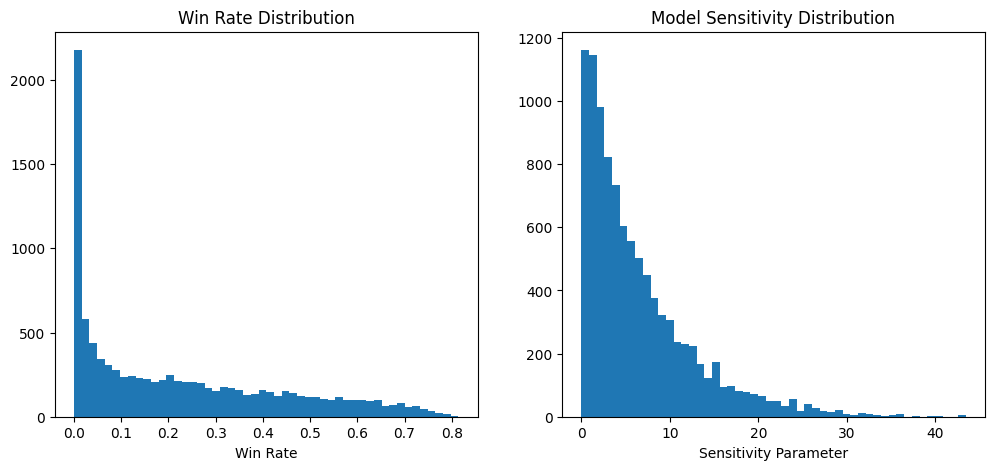

In [7]:
win_rate_test, max_win_rate_test, bias_test, sensitivity_test = model(features_test_tensor, price_test_tensor)

pred_win_rate_test = win_rate_test.detach().numpy()
pred_max_win_rate_test = max_win_rate_test.detach().numpy()
pred_bias_test = bias_test.detach().numpy()
pred_sensitivity_test = sensitivity_test.detach().numpy()

pred_goods_test = pd.concat(
    [
        product_info[product_info.index.isin(X_test.index)].reset_index(), 
        pd.Series(pred_win_rate_test.ravel(), name="predicted_win_rate"),
        pd.Series(pred_sensitivity_test.ravel(), name="predicted_sensitivity"),
    ], 
    axis=1,
)

conversion_accuracy = ((pred_win_rate_test > 0.5).astype(int).ravel() == y_test.values).mean()
print(f"Prediction accuracy at threshold 0.5: {conversion_accuracy:.2%}")

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(pred_goods_test["predicted_win_rate"], bins=50)
ax[0].set_title("Win Rate Distribution")
ax[0].set_xlabel("Win Rate")

ax[1].hist(pred_goods_test["predicted_sensitivity"], bins=50)
ax[1].set_title("Model Sensitivity Distribution")
ax[1].set_xlabel("Sensitivity Parameter")

plt.show()

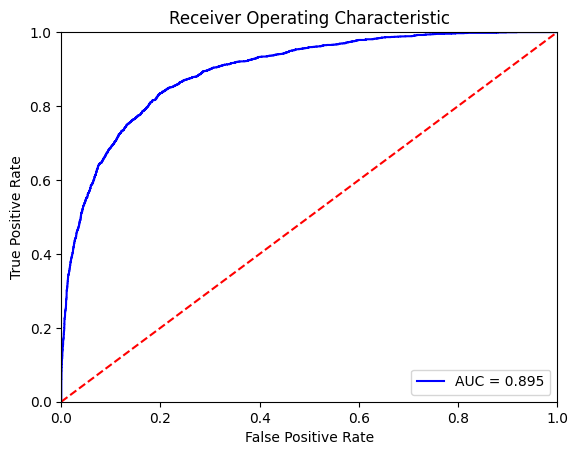

In [8]:
fpr, tpr, threshold = roc_curve(y_test_tensor, pred_win_rate_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f"AUC = {roc_auc_score(y_test_tensor, pred_win_rate_test):.3}")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

___
## Analyze Price-Response Function Parameters

In [9]:
categorical_features_test = pd.concat(
    [
        pd.from_dummies(X_test[[x for x in training_data.columns if "goods_type" in x]], sep="_"),
        pd.from_dummies(X_test[[x for x in training_data.columns if "brand_tier" in x]], sep="_"),
    ],
    axis=1,
).reset_index()

pred_test_params = pd.DataFrame({
    "predicted_win_rate": pred_win_rate_test.ravel(), 
    "max_win_rate_param": pred_max_win_rate_test.ravel(),
    "bias_param": pred_bias_test.ravel(),
    "sensitivity_param": pred_sensitivity_test.ravel(),
})

pred_analysis = pd.concat(
    [
        X_test[["past_spending", "price", "quantity", "membership_flag"]].reset_index(),
        categorical_features_test,
        price_test["price"].reset_index().drop(columns="index").rename(columns={"price": "price_index"}),
        pred_test_params,
        y_test.reset_index().drop(columns="index"),
    ], 
    axis=1
).drop(columns="index")

pred_analysis.describe().round(3)

,past_spending,price,quantity,membership_flag,price_index,predicted_win_rate,max_win_rate_param,bias_param,sensitivity_param,ordered
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1086.665,121.636,5.461,0.497,0.360,0.221,0.677,-0.278,6.492,0.207
std,865.351,121.023,2.870,0.500,0.214,0.215,0.093,0.499,6.238,0.405
min,0.000,0.317,1.000,0.000,-0.002,0.000,0.519,-1.708,0.000,0.000
25%,329.370,40.719,3.000,0.000,0.192,0.024,0.602,-0.589,1.919,0.000
50%,1004.610,77.252,5.000,0.000,0.333,0.159,0.662,-0.090,4.563,0.000
75%,1683.905,161.101,8.000,1.000,0.502,0.373,0.743,0.133,9.152,0.000
max,4653.040,746.237,10.000,1.000,1.039,0.814,0.962,0.246,43.425,1.000


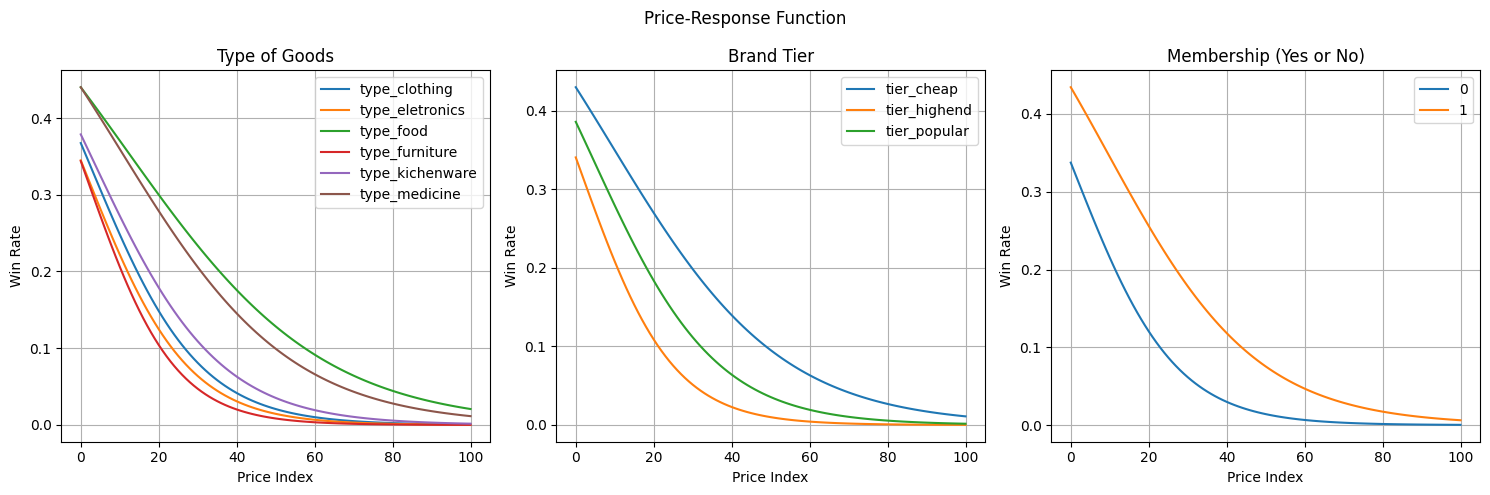

In [10]:
def price_response_function(params, price):
    return params[0] / (1 + np.exp(params[1] + params[2] * price))

def price_response_plot(feature, ax, title):
    avg_params_by_feature = pred_analysis.groupby(feature)[
        ["max_win_rate_param", "bias_param", "sensitivity_param", "predicted_win_rate", "price_index"]
    ].mean()
    for value in avg_params_by_feature.index:
        avg_params = avg_params_by_feature.loc[value].values
        prices = np.linspace(0, 1, 101)
        responses = [price_response_function(avg_params[:-1], x) for x in prices]
        ax.plot(responses, label=value)
        ax.set_title(title)
        ax.set_xlabel("Price Index")
        ax.set_ylabel("Win Rate")
    ax.legend()
    ax.grid()
    return avg_params_by_feature

fig, ax = plt.subplots(1,3,figsize=(15,5))

goods_type_price_response = price_response_plot("goods", ax[0], "Type of Goods")
brand_price_response = price_response_plot("brand", ax[1], "Brand Tier")
membership_price_response = price_response_plot("membership_flag", ax[2], "Membership (Yes or No)")

plt.suptitle("Price-Response Function")
plt.tight_layout()

Cheap Brand may need -15.2% price change for 2.1% revenue increase
Popular Brand may need -41.3% price change for 27.7% revenue increase
High-end Brand may need -57.6% price change for 102.5% revenue increase


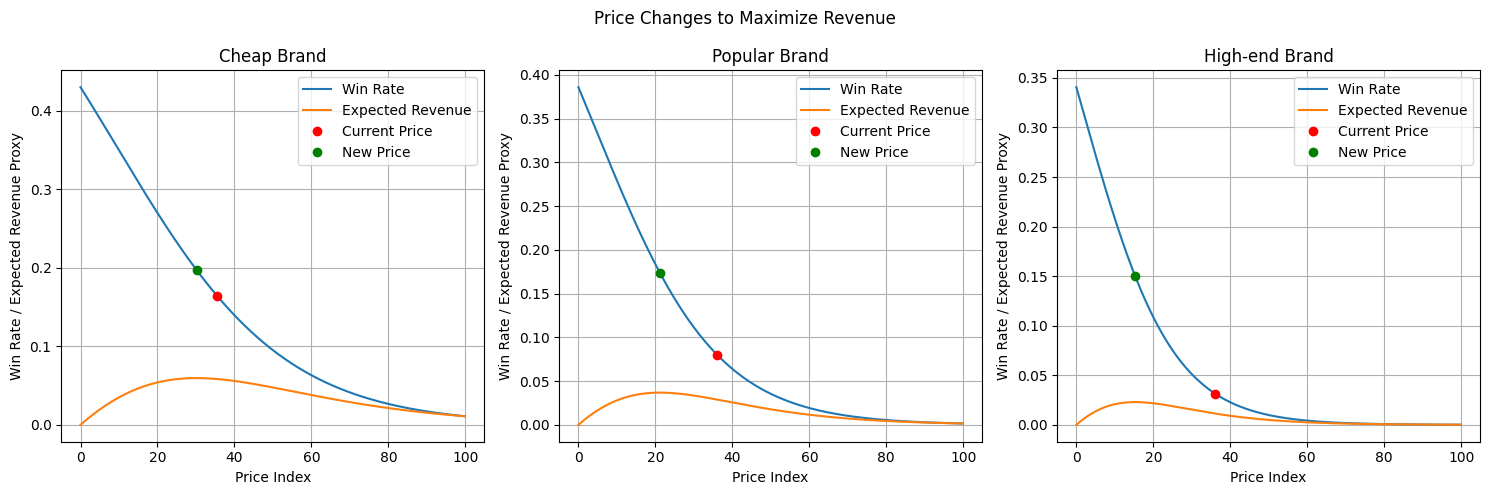

In [11]:
def new_price_expected_revenue(_df, plot=False, ax=None, title=None):
    params = _df[["max_win_rate_param", "bias_param", "sensitivity_param"]].values
    # Calculate win rate and expected revenue
    price_win_rate = [price_response_function(params, x) for x in np.linspace(0, 1, 1000)]
    expected_revenue = price_win_rate * np.linspace(0, 1, 1000)
    # Find current and new price indices
    current_price_index = int(_df["price_index"] * 1000)
    new_price_index = np.argmax(expected_revenue)
    price_change = new_price_index / current_price_index - 1
    expected_revenue_change = expected_revenue[new_price_index] / expected_revenue[current_price_index] - 1
    if plot:
        print(f"{title} may need {price_change:.1%} price change for {expected_revenue_change:.1%} revenue increase")
        ax.plot(price_win_rate, label="Win Rate")
        ax.plot(expected_revenue, label="Expected Revenue")
        ax.plot(current_price_index, price_win_rate[current_price_index], "ro", label="Current Price")
        ax.plot(new_price_index, price_win_rate[new_price_index], "go", label="New Price")
        ax.set_title(title)
        ax.set_xticks(np.arange(0, 1001, 200), np.arange(0, 101, 20))
        ax.set_xlabel("Price Index")
        ax.set_ylabel("Win Rate / Expected Revenue Proxy")
        ax.legend()
        ax.grid()
    return price_win_rate


fig, ax = plt.subplots(1,3,figsize=(15,5))
plt.suptitle("Price Changes to Maximize Revenue")
new_price_expected_revenue(brand_price_response.loc["tier_cheap"], True, ax[0], "Cheap Brand")
new_price_expected_revenue(brand_price_response.loc["tier_popular"], True, ax[1], "Popular Brand")
new_price_expected_revenue(brand_price_response.loc["tier_highend"], True, ax[2], "High-end Brand")
plt.tight_layout()

___
## Price Optimization

In [12]:
pred_analysis.groupby(["goods", "ordered"])["price_index"].describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]).round(3)

count   mean    std    min    25%    50%    75%  \
goods           ordered                                                     
type_clothing   0        1383.0  0.363  0.218  0.000  0.194  0.334  0.511   
                1         292.0  0.344  0.210  0.003  0.183  0.324  0.504   
type_eletronics 0        1448.0  0.365  0.212  0.001  0.200  0.341  0.491   
                1         204.0  0.358  0.217  0.016  0.200  0.307  0.489   
type_food       0        1097.0  0.353  0.209  0.000  0.188  0.334  0.500   
                1         531.0  0.367  0.217  0.004  0.187  0.342  0.506   
type_furniture  0        1458.0  0.362  0.214 -0.000  0.193  0.330  0.505   
                1         201.0  0.375  0.203  0.008  0.228  0.361  0.512   
type_kichenware 0        1381.0  0.366  0.215 -0.002  0.198  0.340  0.504   
                1         351.0  0.353  0.212  0.006  0.183  0.322  0.502   
type_medicine   0        1161.0  0.350  0.216  0.000  0.184  0.319  0.494   
                1         493.0  0.353  0.220  0.005  0.183  0.331  0.482   

                           80%    85%    90%    95%  97.5%    99%    max  
goods           ordered                                                   
type_clothing   0        0.553  0.600  0.663  0.768  0.843  0.947  0.989  
                1        0.553  0.587  0.627  0.708  0.753  0.873  0.979  
type_eletronics 0        0.544  0.595  0.663  0.771  0.845  0.931  1.026  
                1        0.537  0.617  0.683  0.746  0.851  0.960  0.977  
type_food       0        0.540  0.583  0.638  0.716  0.780  0.929  1.021  
                1        0.566  0.622  0.674  0.772  0.829  0.902  0.982  
type_furniture  0        0.550  0.606  0.667  0.767  0.825  0.894  1.026  
                1        0.562  0.598  0.637  0.722  0.810  0.922  0.956  
type_kichenware 0        0.552  0.602  0.660  0.771  0.858  0.926  0.996  
                1        0.538  0.565  0.625  0.720  0.840  0.928  1.032  
type_medicine   0        0.531  0.589  0.661  0.735  0.830  0.936  1.039  
                1        0.521  0.594  0.662  0.766  0.867  0.959  1.014

In [13]:
price_limits = pred_analysis[pred_analysis["ordered"] == 1].groupby("goods")["price_index"].quantile(0.99).to_dict()
price_eligible_mask = pred_analysis.apply(lambda x: x["price_index"] < price_limits.get(x["goods"]), axis=1)
optimization_eligible_products = pred_analysis[price_eligible_mask]

def price_optimization(
    membership_coef=0, 
    type_food_coef=0,
    type_medicine_coef=0,
    type_kichenware_coef=0,
    type_clothing_coef=0,
    type_electronics_coef=0,
    type_furniture_coef=0,
    tier_cheap_coef=0,
    tier_popular_coef=0,
    tier_highend_coef=0,
):
    optimization_eligible_products["price_change"] = (
        membership_coef * optimization_eligible_products["membership_flag"] 
        + optimization_eligible_products["goods"].apply(
            lambda x: type_food_coef if x == "type_food"
            else type_medicine_coef if x == "type_medicine"
            else type_kichenware_coef if x == "type_kichenware"
            else type_clothing_coef if x == "type_clothing"
            else type_electronics_coef if x == "type_electronics"
            else type_furniture_coef
        )
        + optimization_eligible_products["brand"].apply(
            lambda x: tier_cheap_coef if x == "tier_cheap"
            else tier_popular_coef if x == "tier_popular"
            else tier_highend_coef
        )
    )
    optimization_eligible_products["new_price_index"] = (
        optimization_eligible_products["price_index"] 
        * (1 + optimization_eligible_products["price_change"])
    )
    optimization_eligible_products["new_predicted_win_rate"] = optimization_eligible_products.apply(
        lambda x: price_response_function(
            x[["max_win_rate_param", "bias_param", "sensitivity_param"]].values, 
            x["new_price_index"],
        ),
        axis=1,
    )
    return (
        optimization_eligible_products["new_price_index"] 
        * optimization_eligible_products["new_predicted_win_rate"]
    ).sum()


coef_ranges = {
    "membership_coef": (-0.3, 0.3), 
    "type_food_coef": (-0.3, 0.3),
    "type_medicine_coef": (-0.3, 0.3),
    "type_kichenware_coef": (-0.3, 0.3),
    "type_clothing_coef": (-0.3, 0.3),
    "type_electronics_coef": (-0.3, 0.3),
    "type_furniture_coef": (-0.3, 0.3),
    "tier_cheap_coef":(-0.3, 0.3),
    "tier_popular_coef": (-0.3, 0.3),
    "tier_highend_coef": (-0.3, 0.3),
}

bo = BayesianOptimization(price_optimization, coef_ranges, random_state=123, verbose=True)
bo.maximize(init_points=1, n_iter=5)

|   iter    |  target   | member... | tier_c... | tier_h... | tier_p... | type_c... | type_e... | type_f... | type_f... | type_k... | type_m... |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 3         | 771.6     | 0.2717    | -0.09861  | -0.04321  | 0.2786    | -0.2805   | 0.2968    | 0.2194    | 0.1845    | 0.1043    | 0.245     |
| 6         | 779.3     | 0.2813    | -0.08264  | -0.05648  | 0.2933    | -0.2787   | 0.2976    | 0.2337    | 0.1774    | 0.09225   | 0.2691    |


In [14]:
current_expected_revenue = (optimization_eligible_products["price_index"] * optimization_eligible_products["predicted_win_rate"]).sum()
new_expected_revenue = bo.max.get("target")

print(
    f"Expected Revenue Proxy: current={round(current_expected_revenue)}, new={round(new_expected_revenue)} "
    f"({new_expected_revenue / current_expected_revenue - 1:.1%} increase)\n"
)
print("Recommended Price Changes")
[(x[0], str(round(x[1] * 100, 1)) + "%") for x in bo.max.get("params").items()]

Expected Revenue Proxy: current=656, new=779 (18.9% increase)

Recommended Price Changes


[('membership_coef', '28.1%'),
 ('tier_cheap_coef', '-8.3%'),
 ('tier_highend_coef', '-5.6%'),
 ('tier_popular_coef', '29.3%'),
 ('type_clothing_coef', '-27.9%'),
 ('type_electronics_coef', '29.8%'),
 ('type_food_coef', '23.4%'),
 ('type_furniture_coef', '17.7%'),
 ('type_kichenware_coef', '9.2%'),
 ('type_medicine_coef', '26.9%')]